RNN과 CNN을 사용한 시퀀스 처리에 대해 탐구해본다.

우선 처음으로 해볼 것은 '내일' 버스와 열차에 탑승할 승객 수를 예측하는 모델을 만드는 것이다.

먼저 데이터를 로드하고 정제한다.

In [2]:
import tensorflow as tf

In [3]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership_extracted'

In [4]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # 더 짧은 이름
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # total은 단순히 bus + rail 이므로 삭제합니다.
df = df.drop_duplicates()  # 중복된 월 제거 (2011-10와 2014-07)

csv 파일을 다운로드 하고, 로드하고, 열 이름을 짧게 줄이고, 날짜 순으로 행을 정렬하고, total 열을 삭제하고, 중복 행을 삭제했다.

day_type열은 평일의 경우 W, 토요일은 A, 일요일이나 공휴일은 U이다.

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


2019년의 첫 몇 달을 살펴보자.

지금의 데이터는 **시계열**데이터다. 타임 스텝마다 여러 개의 값이 있기 때문에 **다변량**시계열이다. 버스만 본다면 **단변량**시계열이다.

아래 그래프를 보면 **매주 비슷한 패턴이 반복**되는 것을 볼 수 있다. 이를 주간 **계절성**이라고 한다. 이 경우 패턴이 매우 강력해서 일주일 전 값을 내일 승객 수로 예측해도 매우 좋은 결과를 얻을 것이다. 이를 **단순 예측**이라고 한다.

<Axes: xlabel='date'>

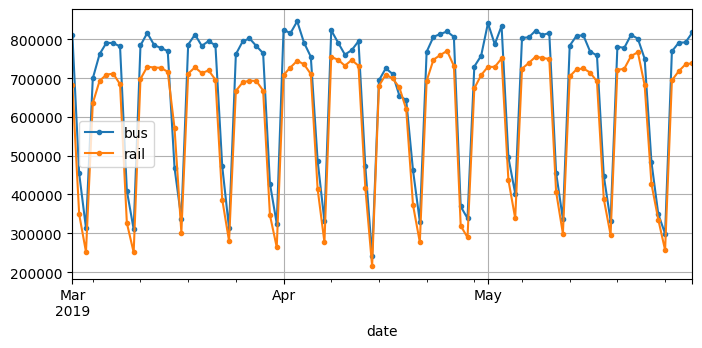

In [6]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))

**단순 예측 결과를 시각화**하기 위해 시계열과 함께 일주일 지연된 시계열을 점선으로 그려본다.

그리고 **두 시계열(원래 시계열, 일주일 지연된 시계열)의 차이**도 그려본다. 이를 **차분**이라고 한다.

그래프를 그려보면 지연된 시계열이 실제 시계열을 잘 따라가고 있다. 시계열이 지연된 자기자신과 상관관계를 가질 때 이를 **자기상관**시계열이라고 한다.

<Axes: xlabel='date'>

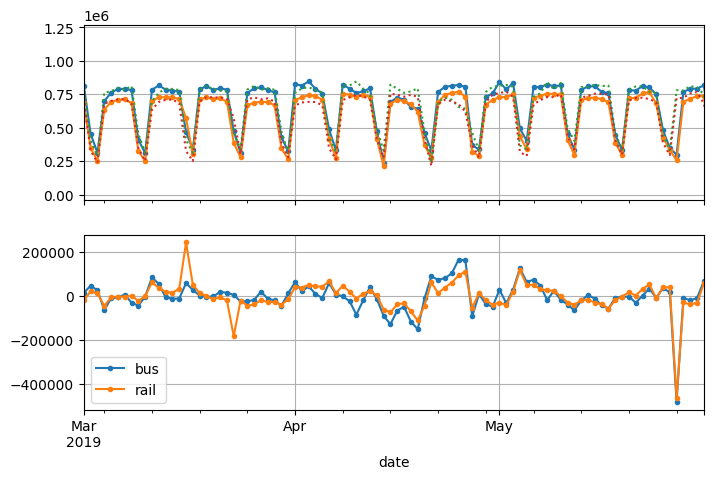

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))

df.plot(ax=axs[0], legend=False, marker=".")  # 원본 시계열 표시
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # 7일 지연 시계열 표시

diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"] # 7일 차분 계산
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7일 차분 시계열 표시

# 차분

차분의 **MAE, MAPE**를 구해보자.

단순예측의 MAE는 버스의 경우 43915명, 열차의 경우 42143명이다.

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

이래서는 이 값이 얼마나 좋은지 나쁜지 단번에 알아채기 어렵기 때문에 예측 오차를 타깃값으로 나누어본다.
쉽게 말해 차분, 각 오차값을 전체값으로 나눈 다음에 MAE계산을 한 것이다. 이게 **MAPE**이다.

버스는 8.3%, 열차는 9%다.

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

# 연간 계절성 확인하기

이 데이터의 경우 월간 계절성은 크게 나타나지 않는다고 한다. 대신 **연간 계절성**을 확인해본다.

장기간 트렌드를 시각화하기 위해 각 시계열의 12개월 **이동평균**을 그려본다.

이동평균이란 단기 변동을 줄이고 장기적인 추세를 파악하기 위해 **일정 기간 동안의 평균**을 계산하는 방법이다.

<Axes: xlabel='date'>

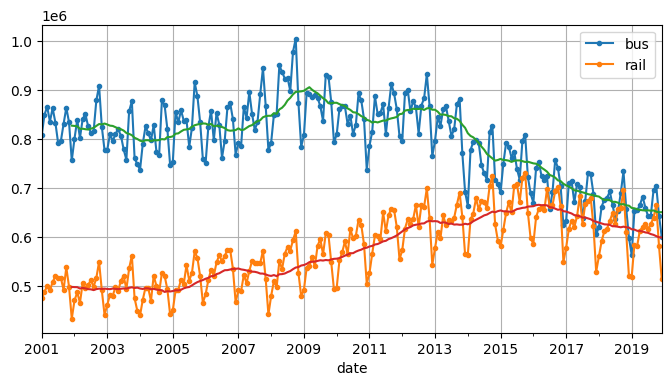

In [10]:
period = slice("2001", "2019") # 기간 설정
df_monthly = df.resample('ME').mean(numeric_only=True)  # 월별 평균을 계산합니다.
rolling_average_12_months = df_monthly[period].rolling(window=12).mean() # 12개월 이동평균 계산

# 시각화
fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".") # 월별 데이터
rolling_average_12_months.plot(ax=ax, grid=True, legend=False) # 12개월 이동평균

앞에서 봤던 주간계절성 보다는 잡음이 있어서 알아보기 힘들긴 하지만 연간 계절성도 분명히 있다. 버스 보다는 열차에서 잘 보인다. 매년 비슷한 시점에서 피크와 바닥을 찍는다.

그러면 이제 12개월 차분을 그려서 어떻게 나오는지 확인해보자.

<Axes: xlabel='date'>

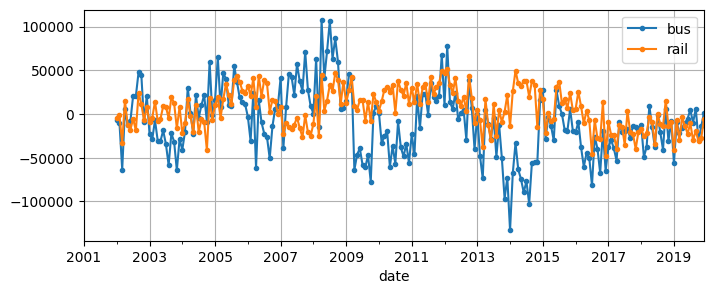

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))

차분은 연간 계절성을 제거할 뿐만 아니라 **장기간 트렌드도 없앤다.**

예를 들어서 2016년에서 2019년까지 버스와 열차에서 일어나는 선형적인 감소트렌드가 차분에서는 거의 일정한 음수값이 되었다.

**차분은 시계열에서 계절성을 제거하기 위해 사용되는 대표적인 기법이다.**

계절성이나 트렌드가 없어서 시간에 따라 통계적 속성이 일정한 **정상 시계열**을 분석하는 것이 더 쉽다.

# ARMA, ARIMA, SARIMA

책에서 기준 모델로 삼을 수 있는 고전적인 모델들에 대해서 설명하는데 일단 여기에서는 패스.

단순 예측의 MAE는 42143, ARMA모델의 MAE는 32041로 나온다. 단순 예측보다는 훨씬 좋음.

# 머신러닝 모델을 위한 데이터 준비

이 작업의 목표는 **과거8주(56일)의 데이터**를 기반으로 **내일의 승객수를 예측**하는 것이다. 따라서 모델의 **입력은 시퀀스**가 될 것이다.

각 시퀀스는 t-55에서 t까지 56개의 값을 담고 있다. 각 시퀀스에 대해 모델은 하나의 값, 즉 타임 스텝 t+1에 대한 예측을 출력한다.

**56일 길이의 window로 자를 수 있는 모든 과거 데이터를 훈련 데이터**로 사용하고, **각 윈도의 다음 값을 타깃**으로 사용한다.

케라스는 이를 위한 `tf.keras.utils.timeseries_dataset_ from_array()` 함수를 제공한다. 시계열을 입력받고 원하는 길이의 모든 윈도와 타깃을 담은 tf.data.Dataset을 만든다.

이제 연습해보자. 아래 코드는 0에서 5까지의 숫자를 담은 시계열을 받아서 길이가 3인 윈도와 타깃을 담은 배치 크기 2의 데이터셋을 만든다.

In [12]:
my_series = [0,1,2,3,4,5]

my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], # 타겟은 4번째 원소부터 시작
    sequence_length=3, # 윈도의 크기는 3
    batch_size=2
)

list(my_dataset)

2025-02-17 20:50:59.670472: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-02-17 20:50:59.670629: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-17 20:50:59.670690: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1739793059.671282 3308631 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1739793059.671358 3308631 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-17 20:50:59.773981: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

위 코드로 생성된 윈도는 [0,1,2] [1,2,3] [2,3,4] 이고 각 타깃은 3,4,5이다. 윈도가 3개만 있어서 마지막 배치는 하나의 윈도만 들어있다.

## Dataset클래스 window() 메서드

조금 복잡하지만 세부적으로 제어할 수 있는 다른 방법도 있음.

In [13]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True): # drop_remainder=True로 지정해서 지정한 window길이보다 작은 window는 삭제한다.
    print(window_dataset) # 중첩된 데이터셋이 반환된다는 것을 확인할 수 있다.

    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
0 1 2 3 
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
1 2 3 4 
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
2 3 4 5 


2025-02-17 20:50:59.796856: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-02-17 20:50:59.797636: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-17 20:50:59.801127: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


window()는 중첩된 데이터셋을 반환한다.

**모델은 입력으로 데이터셋이 아니라 텐서를 기대**하기 때문에 중첩된 데이터셋을 훈련에 바로 사용할 수 없다.

따라서 중첩된 데이터셋을 데이터셋이 아니라 **텐서를 담은 flat dataset으로 변환해주는 flat_map()메서드를 호출해야 한다.**

예를 들어서 {1,2,3}이 텐서 1,2,3으로 구성된 시퀀스를 담은 데이터셋이라고 하자. 중첩된 데이터셋 {{1,2},{3,4},{5,6}}을 펼치면 플랫 데이터셋 {1,2,3,4,5,6}을 얻는다.

또 에를 들어서 `flat_map()`에 `lambda ds: ds.batch(2)`를 전달하면 중첩된 데이터셋 {{1,2},{3,4},{5,6}}을 플랫 데이터셋 {[1,2],[3,4],[5,6]}으로 변환한다. 즉 크기가 2인 텐서 3개를 담은 데이터셋이 되는 것이다.

In [14]:
# 그런데 어차피 flat map으로 펼칠 거라면 굳이 window()함수를 쓰는 이유가 뭐지?
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda ds: ds.batch(4)) # 크기가 4인 텐서를 만든다.
for window in dataset:
    print(window)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)


**이렇게 텐서로 표현된 연속적인 윈도를 담은 데이터셋**이 준비되었다!!!

마지막 단계는 map()메서드를 사용해서 **윈도를 입력과 타깃으로 나누는 것**이다. 여기까지 하면 앞에서 `tf.keras.utils.timeseries_dataset_ from_array()`함수를 사용해서 만든 것과 동일한 결과물을 얻음.

In [15]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True).flat_map(lambda ds: ds.batch(4))
dataset = dataset.map(lambda window: (window[:-1], window[-1])) # 시퀀스를 입력과 타깃으로 쪼갠 다음에 튜플로 감싸서 반환
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

## 실제 데이터 준비!

In [16]:
# 훈련, 검증, 테스트 데이터로 나누고 100만으로 나누어서 대략 0에서 1사이가 되게 한다.
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

이제 `tf.keras.utils.timeseries_dataset_ from_array()`함수를 사용해서 훈련 세트와 검증 세트를 위한 데이터셋을 만든다.

(윈도 안의 내용이 아니라(윈도 안의 내용은 시퀀스이므로 당연히 섞으면 안됨)) 훈련 윈도를 섞기 위해 shuffle=True로 지정한다.

기본적으로 전체 데이터셋을 한 번 섞은 다음에 지정된 배치 크기로 나누어서 처리한다고 한다. 시계열 데이터의 순서는 각 시퀀스 내에서 유지, 시퀀스 단위로 섞임.

In [17]:
seq_length=56

train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

# 검증 데이터는 따로 배치로 묶고 셔플할 필요 없다.
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    seed=42
)

# 선형모델로 예측해보기

먼저 아주 기본적인 선형 모델로 예측해본다. MAE 손실을 직접 최소화 하는 것보다 더 나은 **후버 손실**을 최소화하게 한다.

후버손실은 챕터12에서 직접 구현해봤었는데, MAE와 MSE를 적절히 섞은 방식이다. loss threshold를 기준으로 작으면 MSE, 크면 MAE를 사용한다.



In [99]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length]) # 선형모델이라서 활성화 함수 통과 안시킴
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
                                                     patience=50,
                                                     restore_best_weights=True)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02,
                                    momentum=0.9)

model.compile(loss="huber",
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_ds,
                    epochs=500,
                    validation_data=valid_ds,
                    callbacks=[early_stopping_cb],
                    verbose=2)

Epoch 1/500


/Users/barrett11357/coding/pycharm/handson_ml_--/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 - 0s - 14ms/step - loss: 0.0133 - mae: 0.1245 - val_loss: 0.0052 - val_mae: 0.0812
Epoch 2/500
33/33 - 0s - 5ms/step - loss: 0.0089 - mae: 0.0976 - val_loss: 0.0045 - val_mae: 0.0750
Epoch 3/500
33/33 - 0s - 5ms/step - loss: 0.0078 - mae: 0.0893 - val_loss: 0.0040 - val_mae: 0.0697
Epoch 4/500
33/33 - 0s - 4ms/step - loss: 0.0069 - mae: 0.0833 - val_loss: 0.0043 - val_mae: 0.0711
Epoch 5/500
33/33 - 0s - 4ms/step - loss: 0.0065 - mae: 0.0816 - val_loss: 0.0046 - val_mae: 0.0738
Epoch 6/500
33/33 - 0s - 5ms/step - loss: 0.0059 - mae: 0.0768 - val_loss: 0.0038 - val_mae: 0.0654
Epoch 7/500
33/33 - 0s - 5ms/step - loss: 0.0059 - mae: 0.0773 - val_loss: 0.0053 - val_mae: 0.0787
Epoch 8/500
33/33 - 0s - 5ms/step - loss: 0.0058 - mae: 0.0776 - val_loss: 0.0037 - val_mae: 0.0635
Epoch 9/500
33/33 - 0s - 5ms/step - loss: 0.0053 - mae: 0.0731 - val_loss: 0.0034 - val_mae: 0.0582
Epoch 10/500
33/33 - 0s - 5ms/step - loss: 0.0047 - mae: 0.0673 - val_loss: 0.0033 - val_mae: 0.0591
Epoch 11/5

In [100]:
# 검증 데이터셋에 대한 평가
loss, mae = model.evaluate(valid_ds)
print(f'검증 데이터 손실: {loss:.4f}')
print(f'검증 데이터 MAE: {mae*1e6}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0022 - mae: 0.0377
검증 데이터 손실: 0.0022
검증 데이터 MAE: 37650.74536204338


선형모델로 예측했을 떄의 검증 MAE는 37650명이다. 단순 예측보다는 좋은데, ARMA 모델보다는 딸린다.

# 간단한 RNN으로 예측하기

하나의 순환뉴런을 가진 순환 층 하나로 구성된 가장 간단한 RNN을 사용해 본다.

케라스의 모든 순환 층은 [batch_size, time_step, dimensionality]크기의 3차원 입력을 기대한다. 여기에서 dimensionality는 단변량이면 1, 다변량이면 1보다 큼.

**`input_shape`매개변수에는 첫 번째 차원을 제외하고 지정한다는 것을 기억하자!**

**순환 층은 어떤 크기의 입력 시퀀스도 받을 수 있기 때문**에 두 번째 차원을 **모든 크기를 의미하는 None**으로 지정할 수 있다.

그래서 아래 코드에서 `input_shape=[None, 1]`로 설정한 것이다.

그리고 RNN층에서 **`return_sequences=False`로 지정**해서 **마지막 출력만 반환하는 시퀀스-투-벡터 모델**로 만들었다.

In [18]:
# 추가 코드 - 여러 번 재사용할 유틸리티 함수를 정의합니다.
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)

    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])

    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])

    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [101]:
# Eager Execution 활성화
#tf.compat.v1.enable_eager_execution()

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

simple_rnn_mae = fit_and_evaluate(model, train_ds, valid_ds, 0.02)
print(simple_rnn_mae)

Epoch 1/500


/Users/barrett11357/coding/pycharm/handson_ml_--/.venv/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 582ms/step - loss: 0.0579 - mae: 0.2985 - val_loss: 0.0118 - val_mae: 0.1162
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 574ms/step - loss: 0.0118 - mae: 0.1212 - val_loss: 0.0120 - val_mae: 0.1153
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 580ms/step - loss: 0.0112 - mae: 0.1205 - val_loss: 0.0115 - val_mae: 0.1165
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 575ms/step - loss: 0.0114 - mae: 0.1236 - val_loss: 0.0115 - val_mae: 0.1158
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 576ms/step - loss: 0.0118 - mae: 0.1255 - val_loss: 0.0114 - val_mae: 0.1159
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 584ms/step - loss: 0.0109 - mae: 0.1206 - val_loss: 0.0114 - val_mae: 0.1155
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - loss: 0.0112 - mae: 0.1232 - val_loss: 0.0113 - val_mae: 0.1154
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/step - loss: 0.0114 - mae: 0.1243 - val_loss: 0.0113 - val_mae: 0.1151
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 606ms/ste

KeyboardInterrupt: 

RNN을 훈련시켜보는건 처음인데, 아무래도 타임스텝마다 값을 하나씩 넣어서 그런가 훈련 속도가 되게 느리네. 어차피 mae도 굉장히 높게 나와서 이정도만 돌리고 끝냄.

이번에는 층의 뉴런 수를 32개로 늘려본다. 이 층은 한 타임스텝에서 다음 타임스텝으로 훨씬 많은 정보를 실어 나를 수 있다.

그리고 그 위에 하나의 값을 출력하는 Dense층을 둔다.

RNN층은 마지막에 32차원의 벡터를 반환하고, Dense층이 이를 하나의 출력으로 만든다. 32차원의 최종 출력을 값의 범위가 제한되지 않은 1차원으로 투영하는 것이다.

얘는 더 느리네ㅋㅋ 거의 30~40분 정도 걸린 것 같다.

추가)) **배치 사이즈를 늘려서** GPU를 더 잘 활용하게 해봤다. 원래의 32에서 256으로 늘렸더니 훈련 속도가 훨씬 빨라졌다. 10분 30초 만에 198에포크까지 훈련했고, mae는 28695로 성능은 오히려 소폭 감소했다.

배치 사이즈를 늘린 덕에 좋은 효과를 봤음.

In [21]:
# 배치 사이즈를 늘리면 훈련 속도가 빨라질 수도 있다고 해서 시도해본다.
train_ds_b256 = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=256,
    shuffle=True,
    seed=42
)

추가)) 이번에는 배치 사이즈를 512로 늘려서 실험해보자. 속도는 확실히 더 빠르긴 한데, 초반에 loss가 줄어드는 듯 하다가 오히려 증가하면서 약간 **불안정**한 모습을 보였다. **학습률 예열**과 **학습률 스케줄링**의 필요성이 보인다. 훈련 후반에도 minimum에 수렴하지 못하는 모습을 보임.

6분 57초 만에 199에포크까지 진행하며 속도는 훨씬 빨라졌지만, mae는 29474로 높아졌다.


In [23]:
train_ds_b512 = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=512,
    shuffle=True,
    seed=42
)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1) # 활성화 함수 없음.
])

simple_rnn_mae = fit_and_evaluate(model, train_ds_b512, valid_ds, 0.02)
print(simple_rnn_mae)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step - loss: 0.0946 - mae: 0.3682 - val_loss: 0.0731 - val_mae: 0.3421
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 696ms/step - loss: 0.0499 - mae: 0.2573 - val_loss: 0.0530 - val_mae: 0.2872
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 658ms/step - loss: 0.0619 - mae: 0.3153 - val_loss: 0.0116 - val_mae: 0.1264
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - loss: 0.0168 - mae: 0.1482 - val_loss: 0.0322 - val_mae: 0.2037
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 663ms/step - loss: 0.0228 - mae: 0.1596 - val_loss: 0.0204 - val_mae: 0.1897
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 671ms/step - loss: 0.0254 - mae: 0.1999 - val_loss: 0.0131 - val_mae: 0.1087
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - loss: 0.0156 - mae: 0.1301 - val_loss: 0.0224 - val_mae: 0.1489
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 671ms/step - loss: 0.0170 - mae: 0.1300 - val_loss: 0.0149 - val_mae: 0.1666
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 678ms/step - loss: 0.019

In [103]:
model.save("rnn_with_32_neurons.keras")

mae 28726을 달성했다!!!! ARMA 모델보다 훨씬 좋은 성능을 보인다.

# 심층 RNN으로 예측하기

이렇게 RNN층을 여러개 쌓은 것이 심층 RNN이다.

아래 코드에서 처음 2개의 RNN층은 시퀀스-투-시퀀스 층이고, 마지막 RNN층은 시퀀스-투-벡터 층이다.

얘는 더 심각하게 오래 걸려서 훈련은 패스한다. 책에서 나오기로 이 모델의 MAE는 31211로 썩 좋지 못하다. 얕은 RNN보다 나쁨. 아마도 RNN이 작업에 비해 너무 큰 것 같다고 함.

In [25]:
deepmodel = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(deepmodel, train_ds_b512, valid_ds, 0.02)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.1154 - mae: 0.4352 - val_loss: 0.0131 - val_mae: 0.1443
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0471 - mae: 0.2557 - val_loss: 0.0169 - val_mae: 0.1197
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0332 - mae: 0.1976 - val_loss: 0.0105 - val_mae: 0.0971
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0212 - mae: 0.1681 - val_loss: 0.0177 - val_mae: 0.1747
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0198 - mae: 0.1651 - val_loss: 0.0415 - val_mae: 0.2575
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0275 - mae: 0.1847 - val_loss: 0.0233 - val_mae: 0.1943
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0283 - mae: 0.2094 - val_loss: 0.0195 - val_mae: 0.1496
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0204 - mae: 0.1480 - val_loss: 0.0077 - val_mae: 0.0970
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 0.0130 - mae: 0.1384 - val_loss

KeyboardInterrupt: 